# Problem 2

## Pipeline Summary

* Main classification model (model 1) is VGG16 with one extra linear layer for saving training time
* Ensemble model takes this VGG16 and similarly done ResNet-152 model
* Mean and SD was calculated from dataset rather than taking VGG16 recommended ImageNet dataset mean and sd (slightly different)
* Taken test set as validation set. No cross validation - to keep things simple and accuracy was already pretty good.
* Inference was done for single image (by default randomly selected from test set)


## Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
import copy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob, random, os
from PIL import Image

### CUDA Availibility

In [2]:
# Emptying gpu memory cache
import gc
torch.cuda.empty_cache()
gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"torch.cuda.memory_allocated: {(torch.cuda.memory_allocated(0)/1024/1024/1024)} GB")
    print(f"torch.cuda.memory_reserved: {(torch.cuda.memory_reserved(0)/1024/1024/1024)} GB")

Device: cuda
torch.cuda.memory_allocated: 0.0 GB
torch.cuda.memory_reserved: 0.0 GB


# Dataset Preprocessing

In [3]:
data_dir = '../tmp/dataset_256X256'

### Mean and Standard Deviation of the dataset for normalization

In [4]:
def print_mean_std():

    train_data = datasets.ImageFolder(data_dir + '/train', transform = transforms.ToTensor())
    image_data_loader = DataLoader(train_data,
                                   batch_size=len(train_data),
                                  shuffle=False,
                                  num_workers=0)

    def mean_std_calculate(dataloader):
        images, labels = next(iter(dataloader))
        mean, std = images.mean([0,2,3]), images.std([0,2,3])
        return mean, std

    mean, std = mean_std_calculate(image_data_loader)
    print(f"Mean: {mean}, Standard Deviation: {std}")

# print_mean_std() 
# Mean: [0.4987, 0.4490, 0.3663], Standard Deviation: [0.2693, 0.2581, 0.2784]

### Define Transforms and Augmentations

In [5]:
normalize = transforms.Normalize(
    mean=[0.4987, 0.4490, 0.3663],
    std=[0.2693, 0.2581, 0.2784],
)

train_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(degrees=35),
        transforms.ToTensor(),
        normalize,
])

valid_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
])

### Load Datasets from Folder

In [6]:
train_data = datasets.ImageFolder(data_dir + '/train', 
                                  transform = train_transform)
valid_data = datasets.ImageFolder(data_dir + '/test', 
                                 transform = valid_transform)

print(f"Number of train images = {len(train_data)} & number of test images = {len(valid_data)}")

Number of train images = 4800 & number of test images = 1600


### Preparing data with Dataloader

In [7]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

### Visualizing the Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


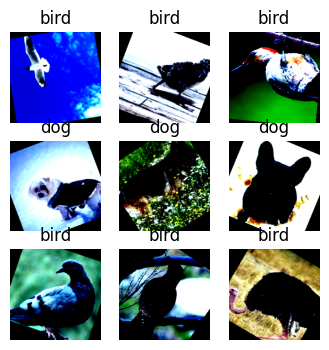

In [8]:
labels_map = {
    0: "berry",
    1: "bird",
    2: "dog",
    3: "flower"
}

figure = plt.figure(figsize=(4, 4))
cols, rows = 3,3
for i in range(1, cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

# Training

### Model Creation

In [9]:
import torchvision.models as models
class Vgg16Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16_pretrained = models.vgg16(weights='VGG16_Weights.DEFAULT')
        self.linear = torch.nn.Linear(1000,4)
    
    def forward(self, x):
        x =  self.vgg16_pretrained(x)
        x = self.linear(x)
        return x

In [10]:
model_vgg16 = Vgg16Classifier()

In [11]:
for param in list(model_vgg16.vgg16_pretrained.parameters()):
                  param.requires_grad = False

In [12]:
summary(model_vgg16, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Vgg16Classifier                          [32, 4]                   --
├─VGG: 1-1                               [32, 1000]                --
│    └─Sequential: 2-1                   [32, 512, 7, 7]           --
│    │    └─Conv2d: 3-1                  [32, 64, 224, 224]        (1,792)
│    │    └─ReLU: 3-2                    [32, 64, 224, 224]        --
│    │    └─Conv2d: 3-3                  [32, 64, 224, 224]        (36,928)
│    │    └─ReLU: 3-4                    [32, 64, 224, 224]        --
│    │    └─MaxPool2d: 3-5               [32, 64, 112, 112]        --
│    │    └─Conv2d: 3-6                  [32, 128, 112, 112]       (73,856)
│    │    └─ReLU: 3-7                    [32, 128, 112, 112]       --
│    │    └─Conv2d: 3-8                  [32, 128, 112, 112]       (147,584)
│    │    └─ReLU: 3-9                    [32, 128, 112, 112]       --
│    │    └─MaxPool2d: 3-10              [32, 128, 56, 56]   

### Hyperparameters

In [13]:
num_classes = 4
num_epochs = 5
learning_rate = 0.005

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg16.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [14]:
def training(model, model_name, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
    
    model.to(device)
    
    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    
    best_train_pred_array = []
    best_train_labels_array = []
    best_valid_pred_array = []
    best_valid_labels_array = []
    
    lowest_val_loss = np.inf
    best_model = None
    
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        
        train_pred_array = []
        train_labels_array = []
        valid_pred_array = []
        valid_labels_array = []
        
        for phase in ['train', 'val']:
            
            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0
            
            if phase == 'train':
                model.train()
                for i, (images, labels) in enumerate(train_dataloader):
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    preds = outputs.argmax(dim=1)
                    correct_items = (preds == labels).float().sum()
                    
                    preds_np = list(preds.cpu().detach().numpy().flatten())
                    labels_np = list(labels.cpu().detach().numpy().flatten())
                    
                    train_pred_array += preds_np
                    train_labels_array += labels_np
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    epoch_loss += loss.item()
                    epoch_correct_items += correct_items.item()
                    epoch_items += len(labels)
                
                print(f'Train Loss: {round(loss.item(), 3)}, Accuracy: {round(100*(epoch_correct_items / epoch_items), 3)}%')
                
                train_loss_array.append(epoch_loss/epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)
                
                
            else:
                model.eval()
                with torch.no_grad():
                    for images, labels in valid_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        preds = torch.argmax(outputs, dim=1)
                        correct_items = (preds == labels).float().sum()
                        
                        preds_np = list(preds.cpu().detach().numpy().flatten())
                        labels_np = list(labels.cpu().detach().numpy().flatten())
                        
                        valid_pred_array += preds_np
                        valid_labels_array += labels_np
                        
                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(labels)

                        del images, labels, outputs
                    
                    print(f'Validation Accuracy: {round(100*(epoch_correct_items / epoch_items),3)}%')
                
                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)
                
                
                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), f'../tmp/{model_name}_weights.pth')
                    best_model = copy.deepcopy(model)
    
                    best_train_pred_array = train_pred_array
                    best_train_labels_array = train_labels_array
                    best_valid_pred_array = valid_pred_array
                    best_valid_labels_array = valid_labels_array
                    
                    print(f"------->> New lowest val loss for {model_name}: {round(lowest_val_loss,3)}")

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array, \
            best_train_pred_array, best_train_labels_array, best_valid_pred_array, best_valid_labels_array

In [15]:
vgg16_model_training_result = training(model=model_vgg16,
                            model_name='model_vgg16',
                            train_dataloader=train_dataloader,
                            val_dataloader=valid_dataloader,
                            criterion = criterion,
                            optimizer = optimizer,
                            num_epochs = num_epochs)

Epoch: 1/5
Train Loss: 2.056, Accuracy: 88.792%
Validation Accuracy: 97.312%
------->> New lowest val loss for model_vgg16: 0.005
Epoch: 2/5
Train Loss: 0.221, Accuracy: 90.917%
Validation Accuracy: 97.562%
Epoch: 3/5
Train Loss: 0.246, Accuracy: 91.438%
Validation Accuracy: 96.812%
Epoch: 4/5
Train Loss: 0.73, Accuracy: 91.562%
Validation Accuracy: 97.062%
Epoch: 5/5
Train Loss: 1.066, Accuracy: 91.896%
Validation Accuracy: 97.25%


In [16]:
trained_model_vgg16, train_loss_array, train_acc_array, val_loss_array, val_acc_array,train_pred_array, train_labels_array, valid_pred_array, valid_labels_array  = vgg16_model_training_result

# Inference for a Single Image

In [17]:
from torch.autograd import Variable

def infer(image, model):
    image_class = "None"
    
    image = valid_transform(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        del image, output
    
    return labels_map[pred]

Actual Class: berry
Predicted Class: berry


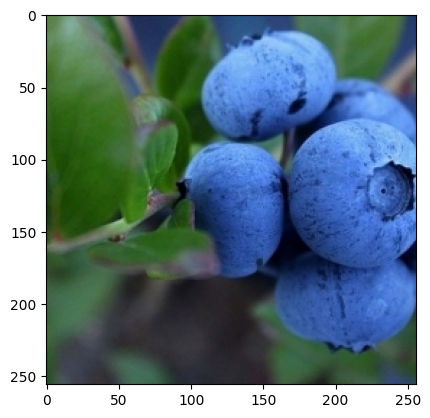

In [48]:
def get_random_image_from_test_set():
    
    dataset_dir = "../tmp/dataset_256X256/test/"
    image_classes = [ f.name for f in os.scandir(dataset_dir) if f.is_dir()]
    selected_class = random.choice(image_classes)
    images = glob.glob(dataset_dir+selected_class+'/'+"*.jpg")
    random_image = Image.open(random.choice(images))
    return selected_class, random_image

selected_class, image = get_random_image_from_test_set()


# Set location for classifying image
# image_loc = "..tmp/dataset_256X256/test/berry/22_256.jpg"
# image = Image.open(image_loc)
# selected_class = image_loc.split("/")[-2]

imgplot = plt.imshow(image)


print(f"Actual Class: {selected_class}")
print(f"Predicted Class: {infer(image, trained_model_vgg16)}")

## Evaluation

In [19]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle(f"{model_name} Training | Batch size: {batch_size}", fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

### Training-Validation Accuracy and Loss

## Why the model is not overfitted ?
As we know, overfitting referes when model is doing too good in training data, which in turn may show poorer result in test data. As the following graphs show, validation loss is lower and accuracy is higher for the model. So, it's safe to assume the model is not overfitted.

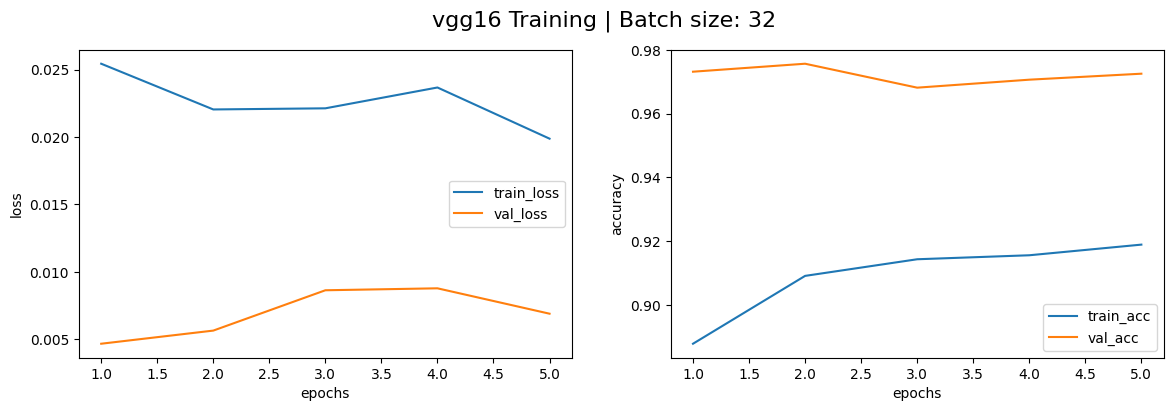

In [20]:
visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="vgg16",
                           batch_size=batch_size)

### Classification Report And Confusion Matrix

              precision    recall  f1-score   support

       berry      0.933     0.975     0.954       400
        bird      0.985     0.993     0.989       400
         dog      0.998     0.998     0.998       400
      flower      0.979     0.927     0.953       400

    accuracy                          0.973      1600
   macro avg      0.974     0.973     0.973      1600
weighted avg      0.974     0.973     0.973      1600



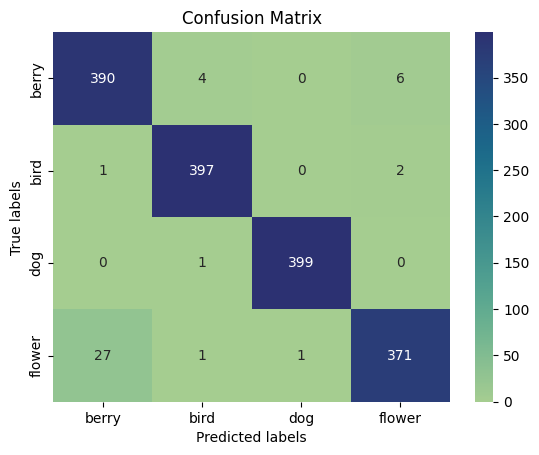

In [21]:
print(metrics.classification_report(valid_labels_array, valid_pred_array, digits=3, target_names=labels_map.values()))

conf_mat = confusion_matrix(valid_labels_array, valid_pred_array)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', cmap="crest",  ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels_map.values()); ax.yaxis.set_ticklabels(labels_map.values());

# Ensembling

In [22]:
torch.cuda.empty_cache()
gc.collect()

class ResNet152Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet152_pretrained = models.resnet152(weights="ResNet152_Weights.DEFAULT")
        self.linear = torch.nn.Linear(1000,4)
    
    def forward(self, x):
        x = self.resnet152_pretrained(x)
        x = self.linear(x)
        return x

In [23]:
model_resnet152 = ResNet152Classifier()

In [24]:
for param in list(model_resnet152.resnet152_pretrained.parameters()):
                  param.requires_grad = False

In [25]:
summary(model_resnet152, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet152Classifier                           [32, 4]                   --
├─ResNet: 1-1                                 [32, 1000]                --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         (70,400)
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]      

### Ensembling 2 Models

In [26]:
class EnsembledModel(nn.Module):
    def __init__(self, model_1, model_2):
        
        super().__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.linear = torch.nn.Linear(8,4)
        
    def forward(self, x):
        x1 = self.model_1(x)
        x2 = self.model_2(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.linear(x)
        return x

In [27]:
model_ensembled = EnsembledModel(model_vgg16, model_resnet152)

In [28]:
summary(model_ensembled, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
EnsembledModel                                     [32, 4]                   --
├─Vgg16Classifier: 1-1                             [32, 4]                   --
│    └─VGG: 2-1                                    [32, 1000]                --
│    │    └─Sequential: 3-1                        [32, 512, 7, 7]           (14,714,688)
│    │    └─AdaptiveAvgPool2d: 3-2                 [32, 512, 7, 7]           --
│    │    └─Sequential: 3-3                        [32, 1000]                (123,642,856)
│    └─Linear: 2-2                                 [32, 4]                   4,004
├─ResNet152Classifier: 1-2                         [32, 4]                   --
│    └─ResNet: 2-3                                 [32, 1000]                --
│    │    └─Conv2d: 3-4                            [32, 64, 112, 112]        (9,408)
│    │    └─BatchNorm2d: 3-5                       [32, 64, 112, 112]        (128)
│  

In [29]:
num_classes = 4
num_epochs = 5
learning_rate = 0.005

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ensembled.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [30]:
ensembled_model_training_result = training(model=model_ensembled,
                            model_name='model_ensembled',
                            train_dataloader = train_dataloader,
                            val_dataloader = valid_dataloader,
                            criterion = criterion,
                            optimizer = optimizer,
                            num_epochs = num_epochs)

Epoch: 1/5
Train Loss: 0.012, Accuracy: 91.417%
Validation Accuracy: 97.188%
------->> New lowest val loss for model_ensembled: 0.003
Epoch: 2/5
Train Loss: 0.095, Accuracy: 96.229%
Validation Accuracy: 98.125%
------->> New lowest val loss for model_ensembled: 0.002
Epoch: 3/5
Train Loss: 0.019, Accuracy: 96.896%
Validation Accuracy: 98.562%
------->> New lowest val loss for model_ensembled: 0.001
Epoch: 4/5
Train Loss: 0.119, Accuracy: 97.729%
Validation Accuracy: 98.438%
------->> New lowest val loss for model_ensembled: 0.001
Epoch: 5/5
Train Loss: 0.078, Accuracy: 97.958%
Validation Accuracy: 98.875%
------->> New lowest val loss for model_ensembled: 0.001


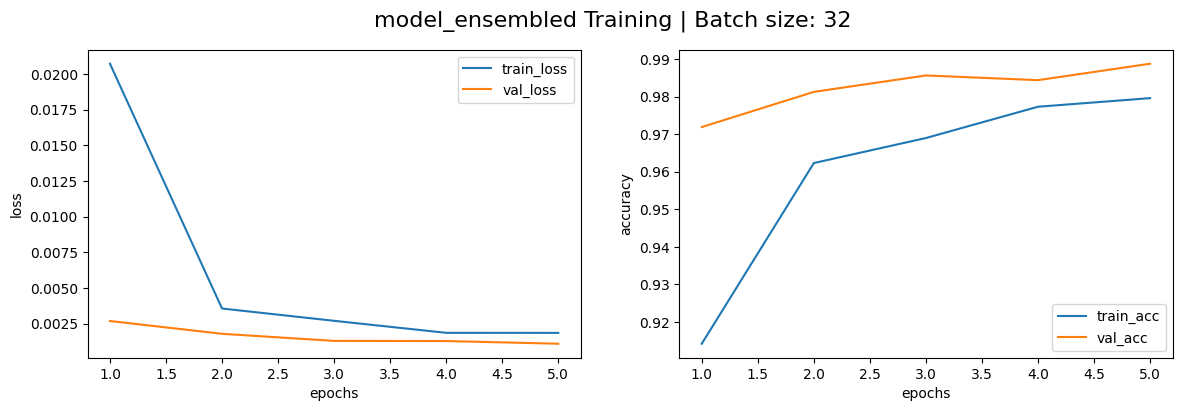

In [31]:
trained_model_ensembled, train_loss_array, train_acc_array, val_loss_array, val_acc_array,train_pred_array, train_labels_array, valid_pred_array, valid_labels_array  = ensembled_model_training_result

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="model_ensembled",
                           batch_size=batch_size)

              precision    recall  f1-score   support

       berry      0.975     0.985     0.980       400
        bird      0.997     0.993     0.995       400
         dog      0.995     1.000     0.998       400
      flower      0.987     0.978     0.982       400

    accuracy                          0.989      1600
   macro avg      0.989     0.989     0.989      1600
weighted avg      0.989     0.989     0.989      1600



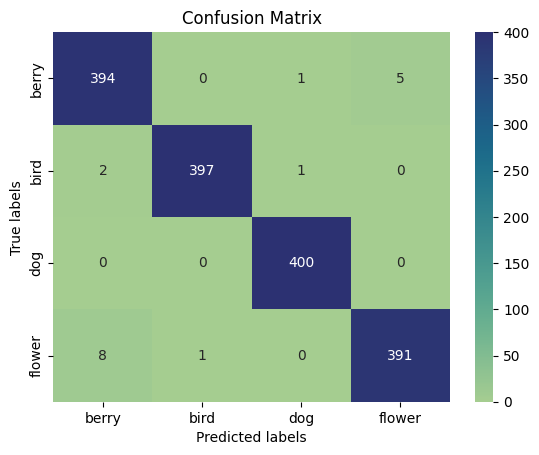

In [32]:
print(metrics.classification_report(valid_labels_array, valid_pred_array, digits=3, target_names=labels_map.values()))

conf_mat = confusion_matrix(valid_labels_array, valid_pred_array)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', cmap="crest",  ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels_map.values()); ax.yaxis.set_ticklabels(labels_map.values());